In [382]:
import kagglehub
import os
import cv2
import matplotlib.pyplot as plt
import SimpleITK as sitk
import ants
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
# Download latest version
# path = kagglehub.dataset_download("happyharrycn/uw-madison-gi-tract-image-segmentation-dataset")
base_path = 'C:\\Users\\rohit\\.cache\\kagglehub\\datasets\\happyharrycn\\uw-madison-gi-tract-image-segmentation-dataset\\versions\\1'
print("Path to dataset files:", base_path)
image_shape = (224,224)

Path to dataset files: C:\Users\rohit\.cache\kagglehub\datasets\happyharrycn\uw-madison-gi-tract-image-segmentation-dataset\versions\1


In [2]:
path1 = os.path.join(os.getcwd(), 'assets', 's3.png')
path2 = os.path.join(os.getcwd(), 'assets', 's4.png')
s1 = cv2.imread(path1,0)
s2 = cv2.imread(path2,0)

In [3]:
mri_image_vector = np.stack([s1.astype('float32'),s2.astype('float32')], axis=0)
raw_image_ants = ants.from_numpy(mri_image_vector)
denoised_mri_ants = ants.denoise_image(raw_image_ants)
denoised_mri = denoised_mri_ants.numpy()
mri_data = sitk.GetImageFromArray(denoised_mri)
transformed = sitk.RescaleIntensity(mri_data, 0, 255)
msk = sitk.LiThreshold(transformed,0,1)
shrink_factor = 3
input_image = sitk.Shrink(mri_data, [shrink_factor]*mri_data.GetDimension())
msk_image = sitk.Shrink(msk, [shrink_factor]*msk.GetDimension())
bfc = sitk.N4BiasFieldCorrectionImageFilter()
corrected = bfc.Execute(mri_data, msk)
bias_field_corrected = bfc.GetLogBiasFieldAsImage(mri_data)
full_resolution_corrected = mri_data/sitk.Exp(bias_field_corrected)

mri_corrected = sitk.GetArrayFromImage(full_resolution_corrected)

corrected_img = mri_corrected[1,:,:]

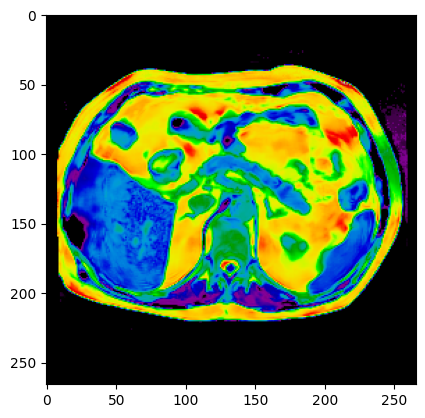

In [4]:
plt.imshow(corrected_img, cmap='nipy_spectral')

In [5]:
normalized = cv2.normalize(corrected_img, None, 0, 255, norm_type=cv2.NORM_MINMAX)

img_ = np.clip(normalized, 0, 255).astype('uint8')
dst = cv2.fastNlMeansDenoising(img_, None,5, 7, 21)
dst = dst.astype('float32')

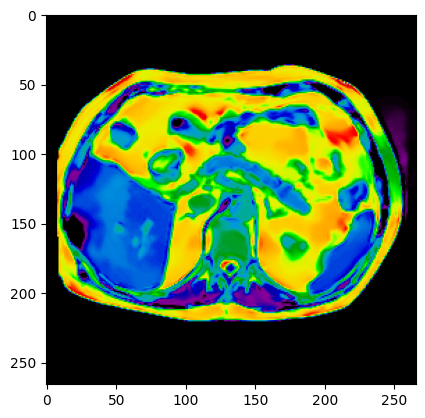

In [6]:
plt.imshow(dst.astype('float32'), cmap='nipy_spectral')

In [56]:
def contruct_VGG16_gray(input_shape=(224,224,1), include_b2 = True, include_b3 = True, include_b4 = True, include_b5 = True):
    output_features = []
    tf.compat.v1.reset_default_graph()
    inputs = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.Conv2D(filters=3, kernel_size=1, padding='same' , trainable = False)(inputs)
    skip_features = x
    vgg16_base = tf.keras.applications.VGG16(weights = 'imagenet', include_top=False)
    
    for layer in vgg16_base.layers:
        layer.trainable = False

    x = vgg16_base.get_layer('block1_conv1')(x)
    x = vgg16_base.get_layer('block1_conv2')(x)
    x = vgg16_base.get_layer('block1_pool')(x)

    output_features.extend([x[0][:,:,i] for i in range(x[0].shape[2])])
    print(f'appended {x.shape} -> total output_feature count: {len(output_features)}')
    if include_b2:
        x = vgg16_base.get_layer('block2_conv1')(x)
        x = vgg16_base.get_layer('block2_conv2')(x)
        x = vgg16_base.get_layer('block2_pool')(x)
        output_features.extend([x[0][:,:,i] for i in range(x[0].shape[2])])
        print(f'appended {x.shape} -> total output_feature count: {len(output_features)}')

    if include_b2 and include_b3:
        x = vgg16_base.get_layer('block3_conv1')(x)
        x = vgg16_base.get_layer('block3_conv2')(x)
        x = vgg16_base.get_layer('block3_conv3')(x)
        output_features.extend([x[0][:,:,i] for i in range(x[0].shape[2])])
        print(f'appended {x.shape} -> total output_feature count: {len(output_features)}')
        x = vgg16_base.get_layer('block3_pool')(x)

    if include_b2 and include_b3 and include_b4:
        x = vgg16_base.get_layer('block4_conv1')(x)
        x = vgg16_base.get_layer('block4_conv2')(x)
        x = vgg16_base.get_layer('block4_conv3')(x)
        output_features.extend([x[0][:,:,i] for i in range(x[0].shape[2])])
        print(f'total output_feature count: {len(output_features)}')
        x = vgg16_base.get_layer('block4_pool')(x)

    if include_b2 and include_b3 and include_b4 and include_b5:
        x = vgg16_base.get_layer('block5_conv1')(x)
        x = vgg16_base.get_layer('block5_conv2')(x)
        x = vgg16_base.get_layer('block5_conv3')(x)
        output_features.extend([x[0][:,:,i] for i in range(x[0].shape[2])])
        print(f'total output_feature count: {len(output_features)}')
    model = tf.keras.models.Model(inputs = inputs, outputs = (x, output_features, skip_features), name= 'VGG16_gray')
    return model

In [57]:
model = contruct_VGG16_gray(input_shape=(224,224,1), include_b4 = False)
model.summary()

appended (None, 112, 112, 64) -> total output_feature count: 64
appended (None, 56, 56, 128) -> total output_feature count: 192
appended (None, 56, 56, 256) -> total output_feature count: 448


Model: "VGG16_gray"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 224, 224,  │          6 │ input_layer_12[0… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ conv2d_6[0][0]    │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[1][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[1][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[1][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[1][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[1][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[1][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[1][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[1][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5395       │ (112, 112, 64)    │          0 │ block1_pool[1][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5397       │ (112, 112, 64)    │          0 │ block1_pool[1][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5399       │ (112, 112, 64)    │          0 │ block1_pool[1][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5401       │ (112, 112, 64)    │          0 │ block1_pool[1][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5403       │ (112, 112, 64)    │          0 │ block1_pool[1][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5405       │ (112, 112, 64)    │          0 │ block1_pool[1][0

 Total params: 1,735,494 (6.62 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,735,494 (6.62 MB)

In [38]:
def reshape_mri(batch_corrected):
    batch_corrected = cv2.resize(batch_corrected, (224,224))
    input_mri = np.expand_dims(batch_corrected, axis=-1)
    input_mri = np.expand_dims(input_mri, axis=0)
    return input_mri

In [416]:
def upsample_features(deep_features, image_shape):
    deep_features_resized = np.zeros((image_shape[0],image_shape[1], deep_features.shape[2]))
    for i in range(deep_features.shape[2]):
        feature = deep_features[:,:,i]
        feature_resized = cv2.resize(feature, image_shape)
        deep_features_resized[:,:,i] = feature_resized
        normalized = cv2.normalize(deep_features_resized[:,:,i], None, 0, 1, norm_type=cv2.NORM_MINMAX)
        deep_features_resized[:,:,i] = np.clip(normalized, 0, 1)
    return deep_features_resized

In [40]:
def stack_image_arrays(img_arr1, img_arr2):
    channel_count = img_arr1.shape[2] + img_arr2.shape[2]
    stacked_images = np.zeros((img_arr1.shape[0], img_arr1.shape[1], channel_count))
    stacked_images[:,:,0:img_arr1.shape[2]] = img_arr1[:,:,0:img_arr1.shape[2]]
    stacked_images[:,:,img_arr1.shape[2]:channel_count] = img_arr2[:,:,0:img_arr2.shape[2]]
    return stacked_images

In [41]:
import math
def view_features(deep_features):
    valid_features = []
    for i in range(deep_features.shape[2]):
        if len(np.unique(deep_features[:, :, i])) > 1:
            valid_features.append(deep_features[:, :, i])
    rows = math.ceil(len(valid_features)/10)
    print(f'{len(valid_features)} valid images found: {rows} rows and 10 columns')
    fig, axes = plt.subplots(nrows = rows, ncols = 10, figsize=(26, 26))
    k=0
    for i in range(rows):
        for j in range(10):
            if k < len(valid_features):
                feature_map = valid_features[k]
                if rows == 1:
                    axes[j].imshow(feature_map, cmap='viridis')
                else:
                    axes[i][j].imshow(feature_map, cmap='viridis')
                k+=1

In [42]:
final_layer_features, output_features, skip_features = model.predict(reshape_mri(dst))

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [43]:
print(len(output_features), output_features[0].shape)

output_features = upsample_features(output_features, image_shape)

skip_features = [skip_features[0][:,:,0],skip_features[0][:,:,1],skip_features[0][:,:,2]]

skip_features = upsample_features(skip_features, image_shape)

print(skip_features.shape, output_features.shape)

features = stack_image_arrays(skip_features, output_features)

print(features.shape)

448 (112, 112)
(224, 224, 3) (224, 224, 448)
(224, 224, 451)


In [44]:
pca_components = 10
flattened_features = output_features.reshape( -1, output_features.shape[2])

In [45]:
pca = PCA(n_components=pca_components)
pca_features = pca.fit_transform(flattened_features)

10 valid images found: 1 rows and 10 columns


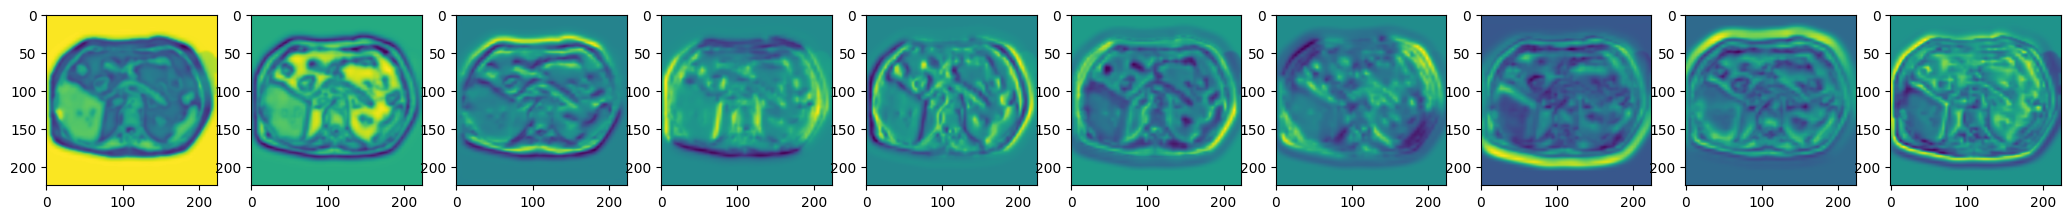

In [46]:
view_features(pca_features.reshape(224,224,pca_components))

In [47]:
print(pca_features.shape)
kmeans = KMeans(n_clusters=6, init='k-means++', random_state=101, n_init=30)
labels = kmeans.fit_predict(pca_features[:,:3])

(50176, 10)


In [48]:
labels_reshaped = labels.reshape(image_shape[0], image_shape[1])
labels_reshaped[labels_reshaped == 0] = 0
labels_reshaped[labels_reshaped == 1] = 51
labels_reshaped[labels_reshaped == 2] = 102
labels_reshaped[labels_reshaped == 3] = 151
labels_reshaped[labels_reshaped == 4] = 202
labels_reshaped[labels_reshaped == 5] = 255

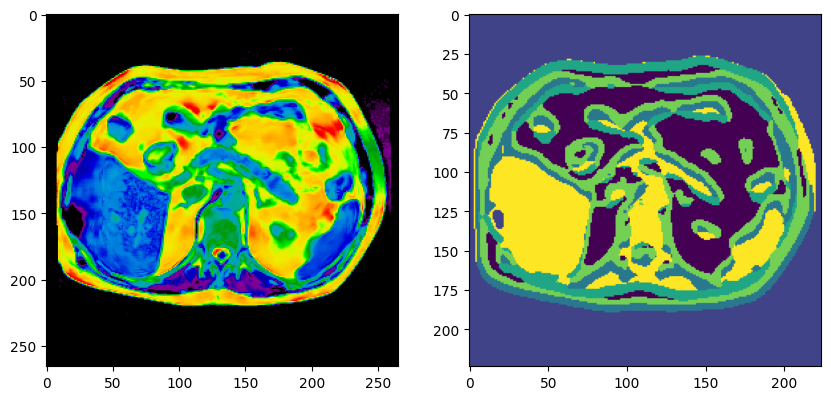

In [49]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(10,10))
axes[0].imshow(corrected_img, cmap='nipy_spectral')
axes[1].imshow(labels_reshaped)

# Attention

In [183]:
def contruct_VGG16_gray(input_shape=(224,224,1), include_b2 = True, include_b3 = True, include_b4 = True, include_b5 = True):
    output_features = []
    tf.compat.v1.reset_default_graph()
    inputs = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.Conv2D(filters=3, kernel_size=1, padding='same' , trainable = False)(inputs)
    output_features.extend([x])
    vgg16_base = tf.keras.applications.VGG16(weights = 'imagenet', include_top=False)
    
    for layer in vgg16_base.layers:
        layer.trainable = False

    x = vgg16_base.get_layer('block1_conv1')(x)
    x = vgg16_base.get_layer('block1_conv2')(x)
    x = vgg16_base.get_layer('block1_pool')(x)

    output_features.extend([x])
    print(f'appended {x.shape} ')
    if include_b2:
        x = vgg16_base.get_layer('block2_conv1')(x)
        x = vgg16_base.get_layer('block2_conv2')(x)
        x = vgg16_base.get_layer('block2_pool')(x)
        output_features.extend([x])
        print(f'appended {x.shape}')

    if include_b2 and include_b3:
        x = vgg16_base.get_layer('block3_conv1')(x)
        x = vgg16_base.get_layer('block3_conv2')(x)
        x = vgg16_base.get_layer('block3_conv3')(x)
        x = vgg16_base.get_layer('block3_pool')(x)
        output_features.extend([x])
        print(f'appended {x.shape}')

    if include_b2 and include_b3 and include_b4:
        x = vgg16_base.get_layer('block4_conv1')(x)
        x = vgg16_base.get_layer('block4_conv2')(x)
        x = vgg16_base.get_layer('block4_conv3')(x)
        x = vgg16_base.get_layer('block4_pool')(x)
        output_features.extend([x])
        print(f'appended {x.shape}')

    if include_b2 and include_b3 and include_b4 and include_b5:
        x = vgg16_base.get_layer('block5_conv1')(x)
        x = vgg16_base.get_layer('block5_conv2')(x)
        x = vgg16_base.get_layer('block5_conv3')(x)
        x = vgg16_base.get_layer('block5_pool')(x)
        output_features.extend([x])
        print(f'appended {x.shape}')
    model = tf.keras.models.Model(inputs = inputs, outputs = output_features, name= 'VGG16_gray')
    return model

In [402]:
model = contruct_VGG16_gray(input_shape=(224,224,1))
model.summary()

appended (None, 112, 112, 64) 
appended (None, 56, 56, 128)
appended (None, 28, 28, 256)
appended (None, 14, 14, 512)
appended (None, 7, 7, 512)


Model: "VGG16_gray"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_30 (InputLayer)     │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_287 (Conv2D)             │ (None, 224, 224, 3)    │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,694 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,694 (56.13 MB)

In [257]:

output_features = model.predict(reshape_mri(corrected_img))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


In [258]:
len(output_features)

6

In [386]:
output_features[2].shape , output_features[3].shape

((1, 56, 56, 128), (1, 28, 28, 256))

In [404]:
x.shape

TensorShape([1, 56, 56, 256])

In [397]:
z = tf.keras.layers.Concatenate(axis=3)([x,y])

In [401]:
tf.keras.layers.MaxPool2D(padding='same')(z)

TensorShape([1, 28, 28, 512])

In [487]:
def attention_gate(vgg16, skip_feature, down_sampled_feature):
    if skip_feature.shape[3] == 3:
        x = vgg16.get_layer('block1_conv1')(skip_feature)
    elif skip_feature.shape[3] == 64:
        x = vgg16.get_layer('block2_conv1')(skip_feature)
    elif skip_feature.shape[3] == 128:
        x = vgg16.get_layer('block3_conv1')(skip_feature)
    elif skip_feature.shape[3] == 256:
        x = vgg16.get_layer('block4_conv1')(skip_feature)
    elif skip_feature.shape[3] == 512:
        x = skip_feature
    skip_feature_down_sampled  = tf.keras.layers.MaxPool2D(padding='same')(x)
    print('downscaled to: ',skip_feature_down_sampled.shape)
    concatenated = tf.keras.layers.Concatenate(axis=3)([skip_feature_down_sampled,down_sampled_feature])
    activated_relu = tf.keras.layers.Activation(activation='relu')(concatenated)
    activated_relu_arr =  activated_relu.numpy()[0]
    activated_relu_normalized = upsample_features(activated_relu_arr, activated_relu_arr.shape[0:2])
    flattened_features = activated_relu_normalized.reshape(-1, activated_relu_arr.shape[2])
    pca = PCA(n_components=1)
    pca_features = pca.fit_transform(flattened_features)
    activation_weights = pca_features.reshape((1, activated_relu_arr.shape[0], activated_relu_arr.shape[1], 1))
    # print(np.max(activation_weights), np.min(activation_weights))
    activated_weights_sigmoid = tf.keras.layers.Activation(activation='sigmoid')(activation_weights)
    # print(tf.reduce_max(activated_weights_sigmoid), tf.reduce_min(activated_weights_sigmoid))
    size = skip_feature.shape[1]// activated_weights_sigmoid.shape[1], skip_feature.shape[1]// activated_weights_sigmoid.shape[1]
    
    # activated_weights_sigmoid_upsampled = tf.image.resize(activated_weights_sigmoid[0:1,:,:,0:1], [skip_feature[0].shape[0],skip_feature[0].shape[1]])
    activated_weights_sigmoid_upsampled = tf.keras.layers.UpSampling2D(size=size)(activated_weights_sigmoid)
    print('upscaled to: ', activated_weights_sigmoid_upsampled.shape)
    y = tf.keras.layers.multiply([skip_feature, activated_weights_sigmoid_upsampled])
    return y.numpy(), activated_weights_sigmoid_upsampled.numpy()

In [455]:
y, weights = attention_gate(model, output_features[2], output_features[3])

upscale by:  (2, 2)


In [447]:
output_features[2][0][:,:,0]

array([[ 9.785083 , 10.76907  , 10.76907  , ..., 10.76907  , 10.784484 ,
        12.35353  ],
       [ 3.5306609,  3.657453 ,  3.657453 , ...,  3.657453 ,  3.709553 ,
         8.840383 ],
       [ 3.403475 ,  3.5360081,  3.5360081, ...,  3.5360081,  3.5898545,
         8.800007 ],
       ...,
       [ 3.403475 ,  3.5360081,  3.5360081, ...,  3.5360081,  3.5898545,
         8.800007 ],
       [ 3.403475 ,  3.5360081,  3.5360081, ...,  3.5360081,  3.5898545,
         8.800007 ],
       [ 2.635816 ,  2.800537 ,  2.800537 , ...,  2.800537 ,  2.8678994,
         7.9052567]], dtype=float32)

In [448]:
y[0][:,:,0]

array([[0.50272876, 0.5532831 , 0.5382943 , ..., 0.53809494, 0.5511889 ,
        0.6313819 ],
       [0.18139495, 0.18790917, 0.1828186 , ..., 0.18275088, 0.18959315,
        0.45182693],
       [0.1709765 , 0.17763442, 0.17021964, ..., 0.17021208, 0.17945603,
        0.43991038],
       ...,
       [0.17084636, 0.1774992 , 0.17007086, ..., 0.1700408 , 0.17937616,
        0.43971458],
       [0.1761668 , 0.18302684, 0.17765468, ..., 0.17769866, 0.1853746 ,
        0.45441893],
       [0.13643211, 0.14495821, 0.14070344, ..., 0.14073826, 0.14809394,
        0.40821537]], dtype=float32)

20 valid images found: 2 rows and 10 columns


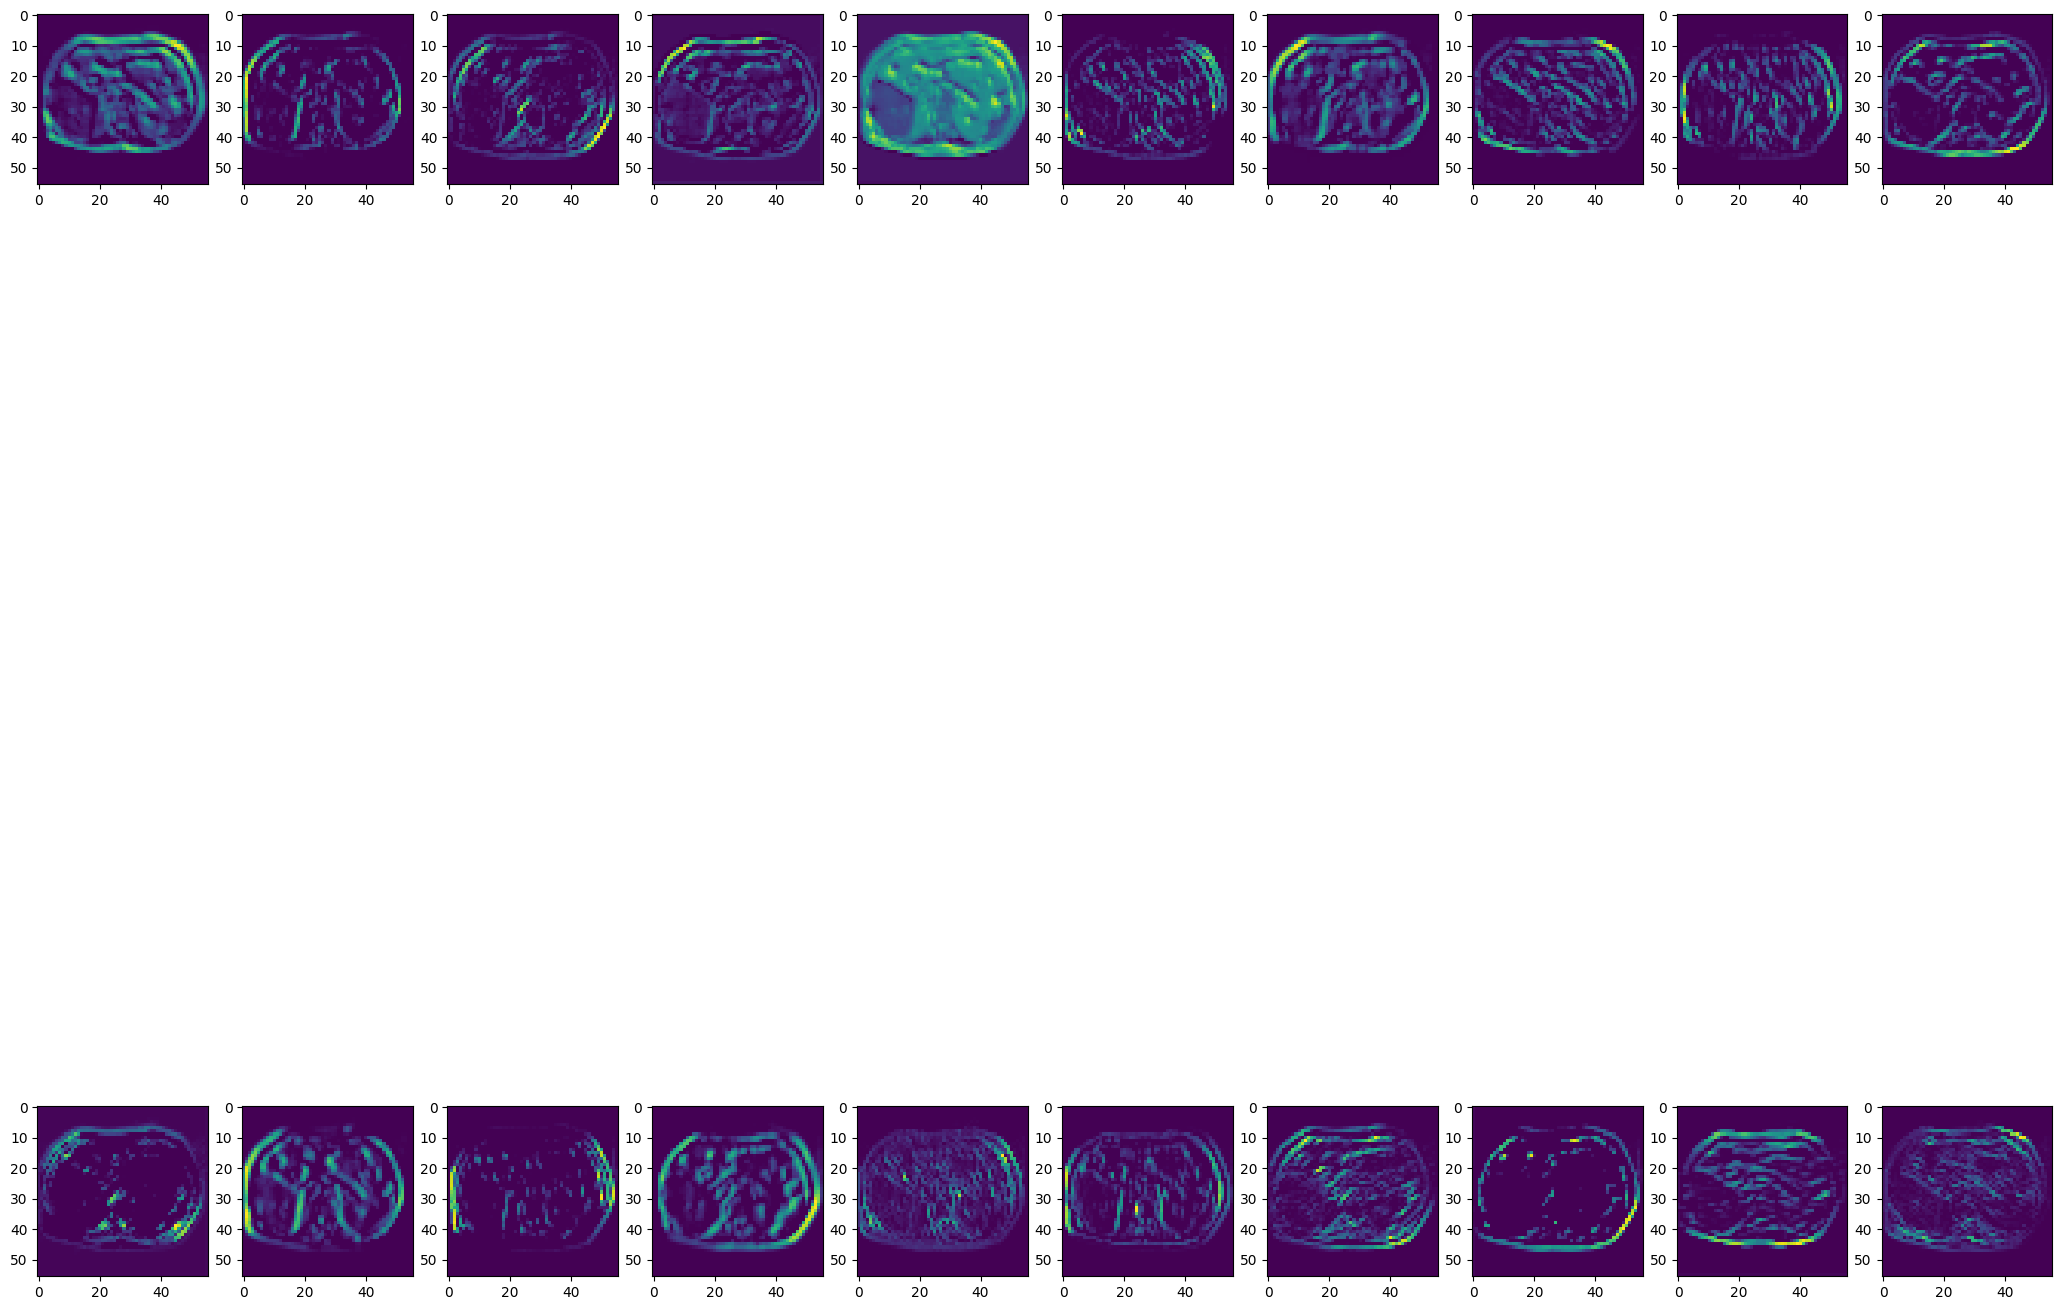

In [449]:
view_features(output_features[2][0][:,:,0:20])

20 valid images found: 2 rows and 10 columns


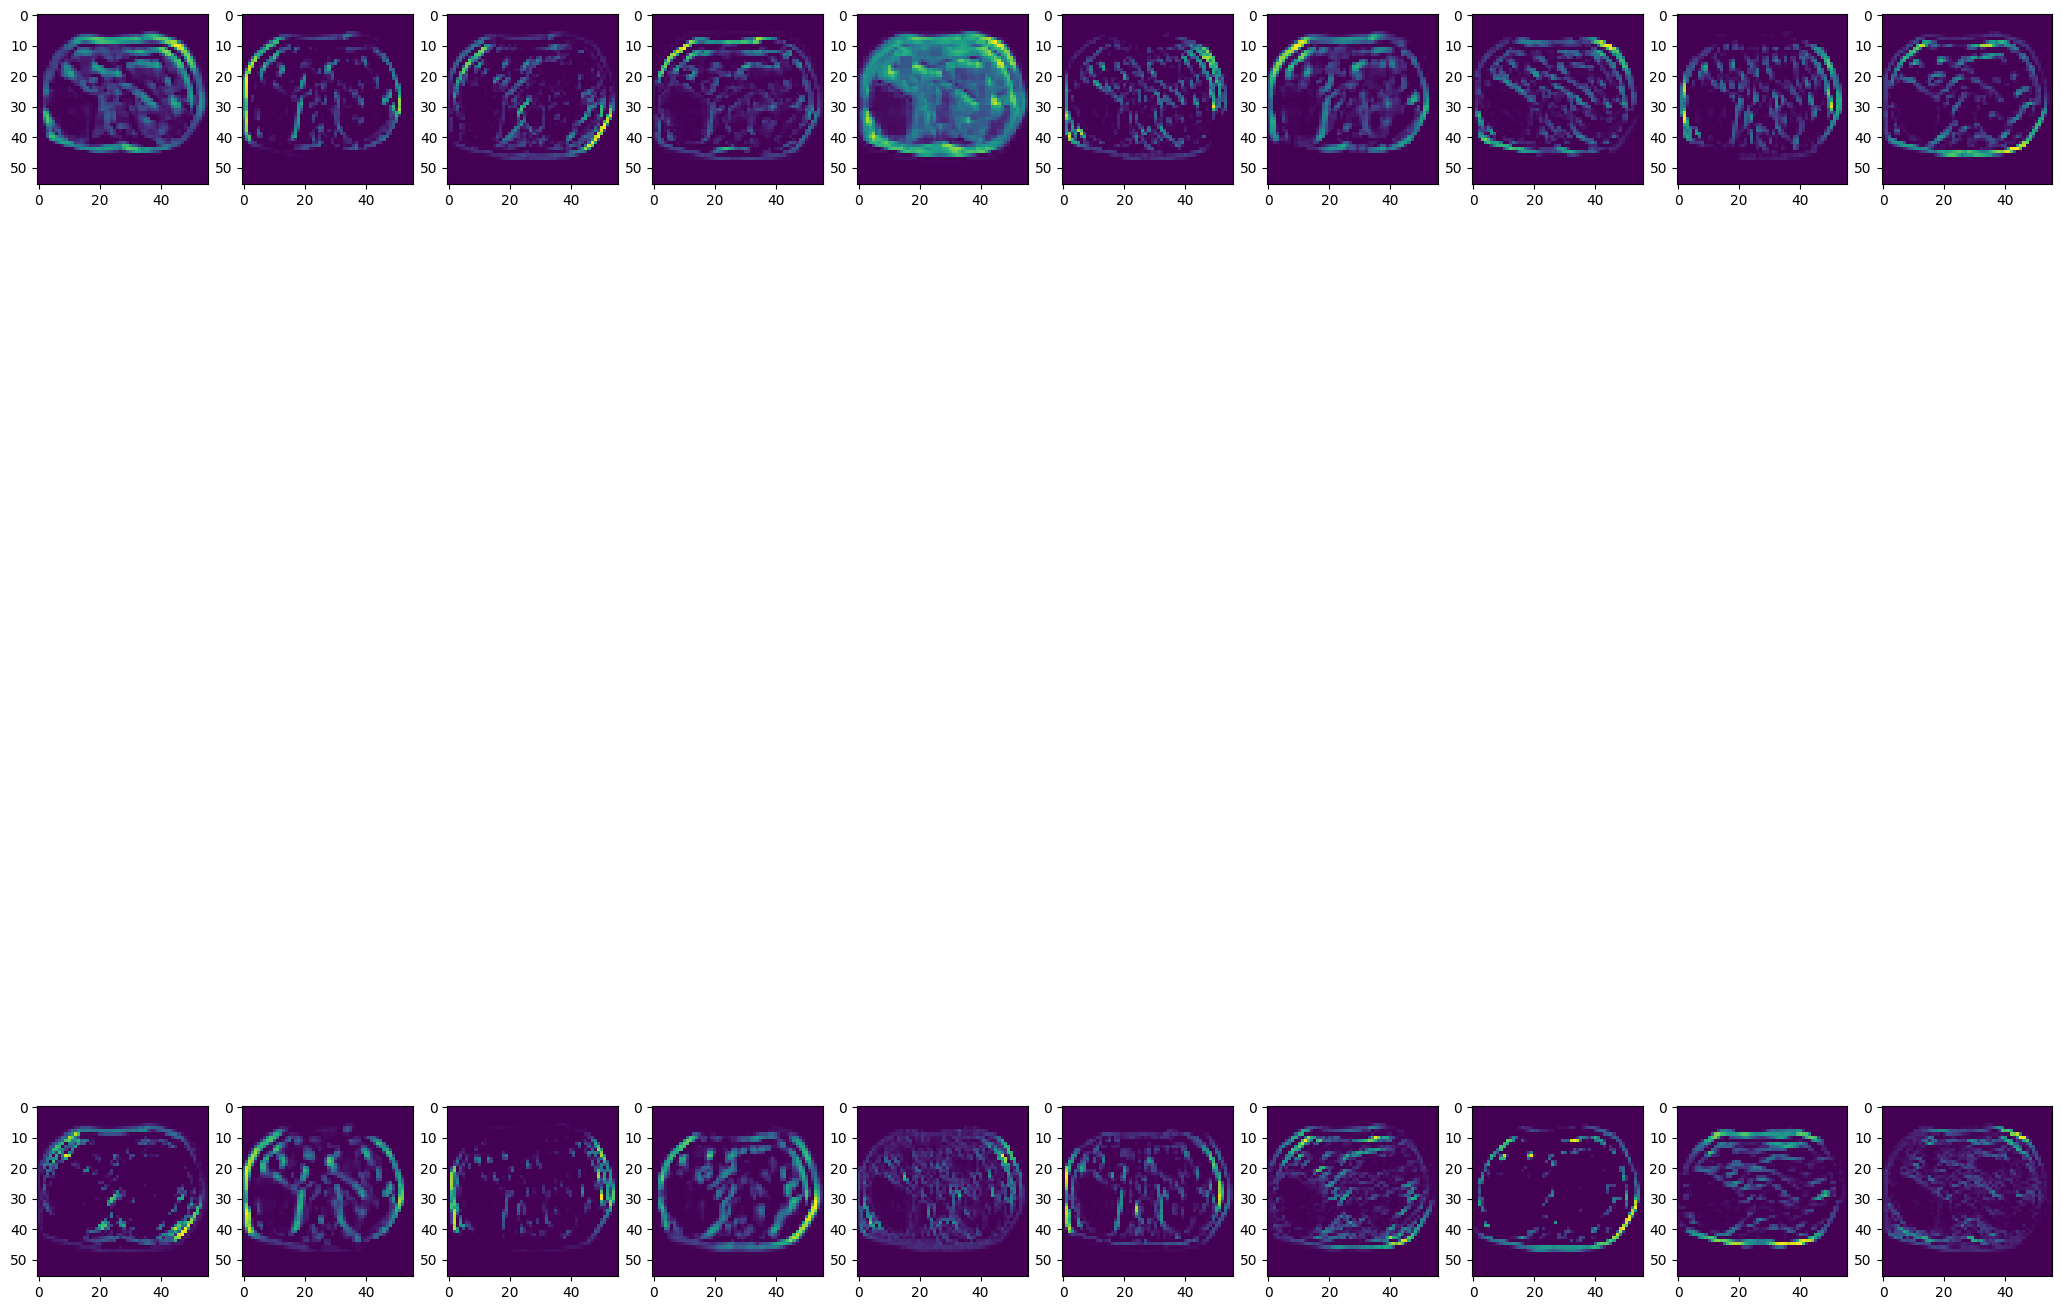

In [450]:
view_features(y[0][:,:,0:20])

In [465]:
weights[0][:,:,0]

array([[0.05137705, 0.05137705, 0.04998522, ..., 0.0499667 , 0.05110943,
        0.05110943],
       [0.05137705, 0.05137705, 0.04998522, ..., 0.0499667 , 0.05110943,
        0.05110943],
       [0.05023586, 0.05023586, 0.04813893, ..., 0.04813679, 0.04998978,
        0.04998978],
       ...,
       [0.05019762, 0.05019762, 0.04809685, ..., 0.04808835, 0.04996753,
        0.04996753],
       [0.05176086, 0.05176086, 0.05024159, ..., 0.05025403, 0.05163847,
        0.05163847],
       [0.05176086, 0.05176086, 0.05024159, ..., 0.05025403, 0.05163847,
        0.05163847]], dtype=float32)

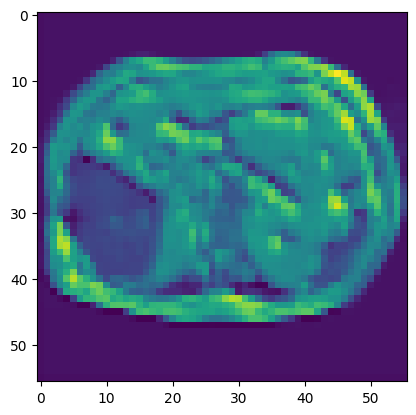

In [467]:
plt.imshow(output_features[2][0][:,:,4])

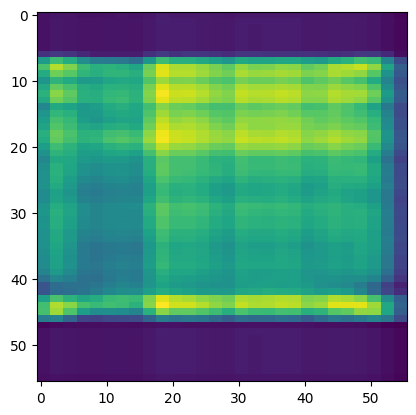

In [469]:
plt.imshow(np.dot(output_features[2][0][:,:,4], weights[0][:,:,0]))

In [474]:
a = output_features[2][0][:,:,4:5]
a = a.reshape((1,56,56,1))

In [475]:
weights.shape

(1, 56, 56, 1)

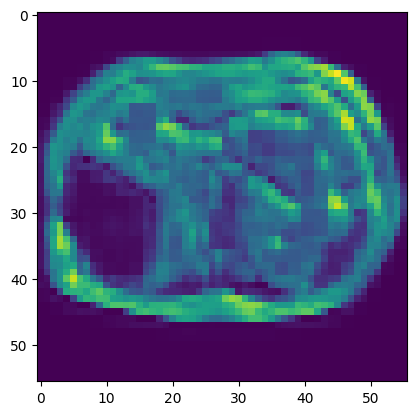

In [479]:
plt.imshow(tf.keras.layers.multiply([a, weights]).numpy()[0,:,:,0])

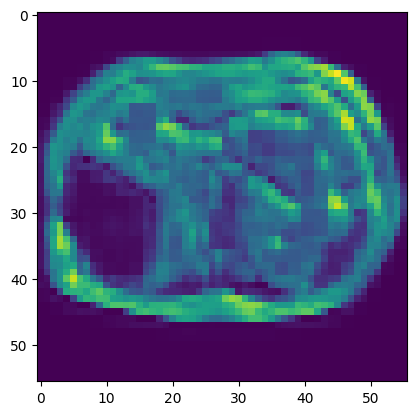

In [481]:
plt.imshow(np.multiply(output_features[2][0][:,:,4], weights[0][:,:,0]))

# Start attention gate : Conv block 4 and 5

In [534]:
y, weights = attention_gate(model, output_features[4], output_features[5])

downscaled to:  (1, 7, 7, 512)
upscaled to:  (1, 14, 14, 1)


10 valid images found: 1 rows and 10 columns


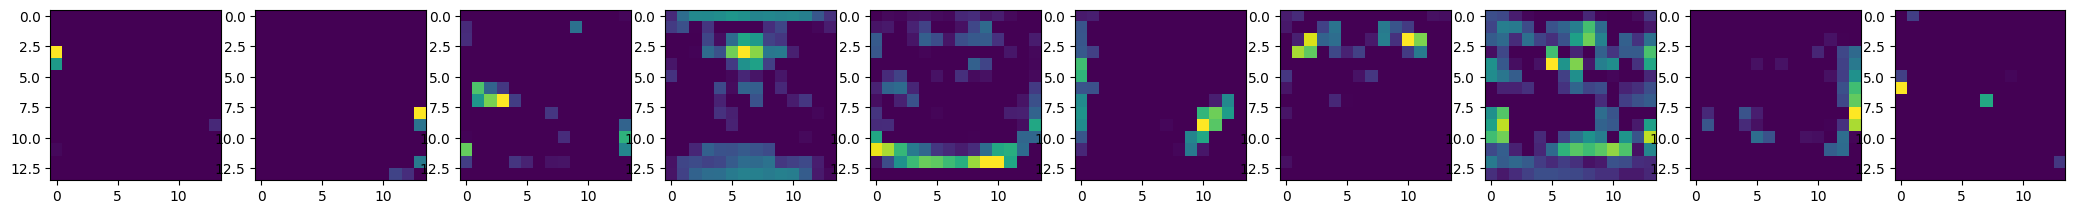

In [535]:
view_features(output_features[4][0][:,:,0:11])

10 valid images found: 1 rows and 10 columns


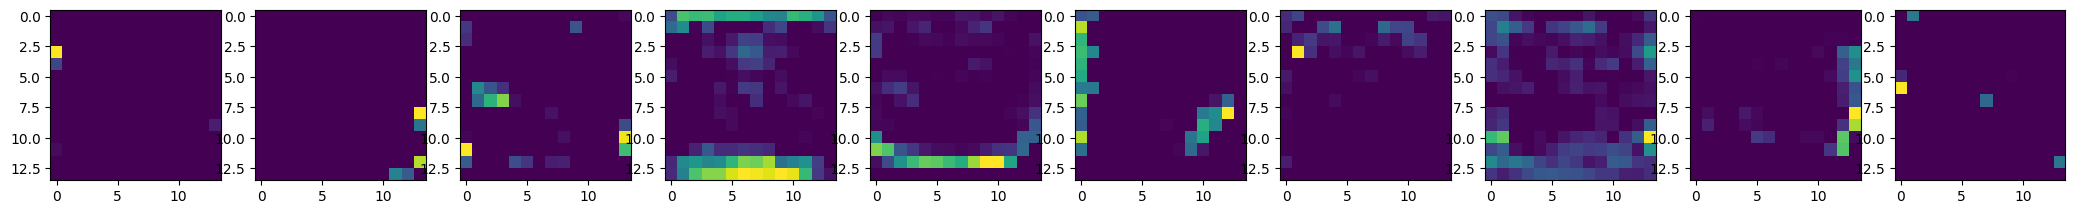

In [536]:
view_features(y[0][:,:,0:11])

## Start attention gate : Conv block 3 and 4x5

In [537]:
y, weights = attention_gate(model, output_features[3], y)

downscaled to:  (1, 14, 14, 512)
upscaled to:  (1, 28, 28, 1)


10 valid images found: 1 rows and 10 columns


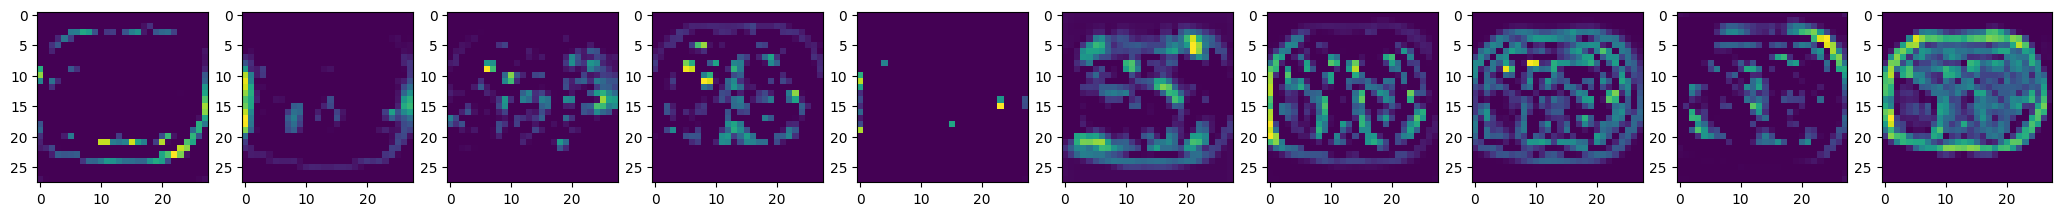

In [538]:
view_features(output_features[3][0][:,:,0:10])

10 valid images found: 1 rows and 10 columns


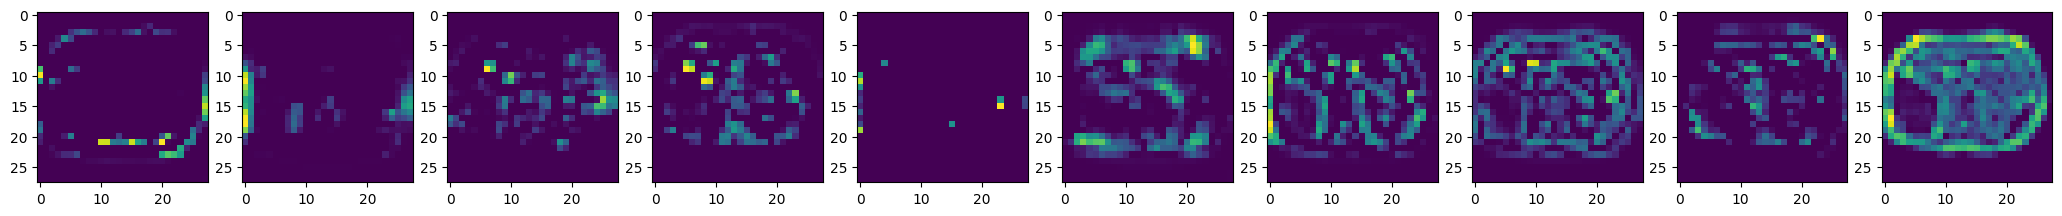

In [539]:
view_features(y[0][:,:,0:10])

In [540]:
y.shape

(1, 28, 28, 256)

## Start attention gate : Conv block 2 and 3x4x5

In [541]:
y, weights = attention_gate(model, output_features[2], y)

downscaled to:  (1, 28, 28, 256)
upscaled to:  (1, 56, 56, 1)


10 valid images found: 1 rows and 10 columns


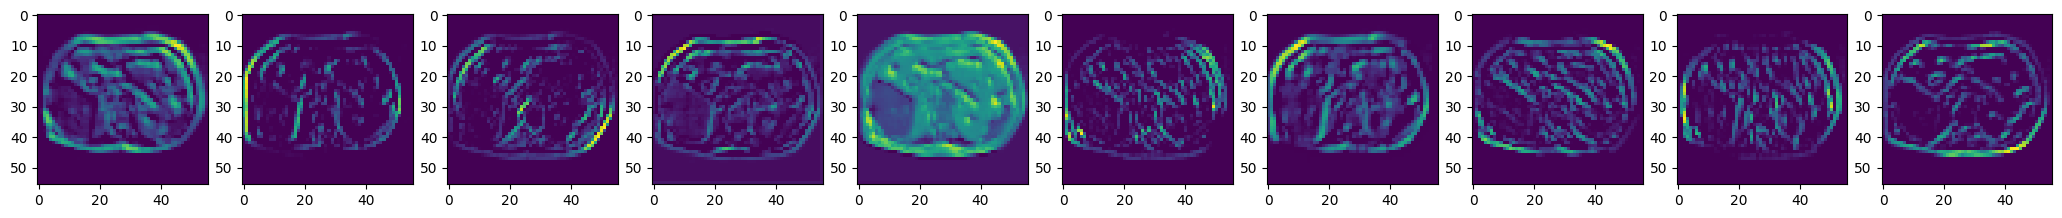

In [542]:
view_features(output_features[2][0][:,:,0:10])

10 valid images found: 1 rows and 10 columns


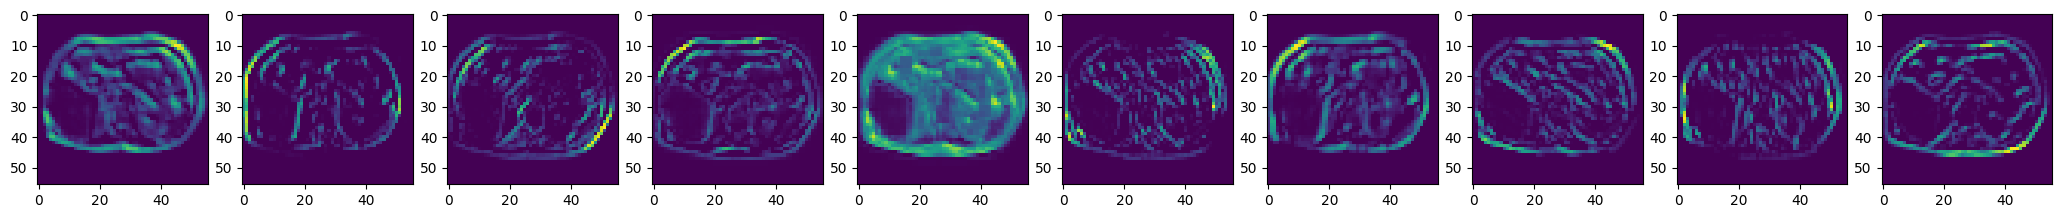

In [543]:
view_features(y[0][:,:,0:10])

In [544]:
y.shape

(1, 56, 56, 128)

## Start attention gate : Conv block 1 and 2x3x4x5

In [545]:
y, weights = attention_gate(model, output_features[1], y)

downscaled to:  (1, 56, 56, 128)
upscaled to:  (1, 112, 112, 1)


10 valid images found: 1 rows and 10 columns


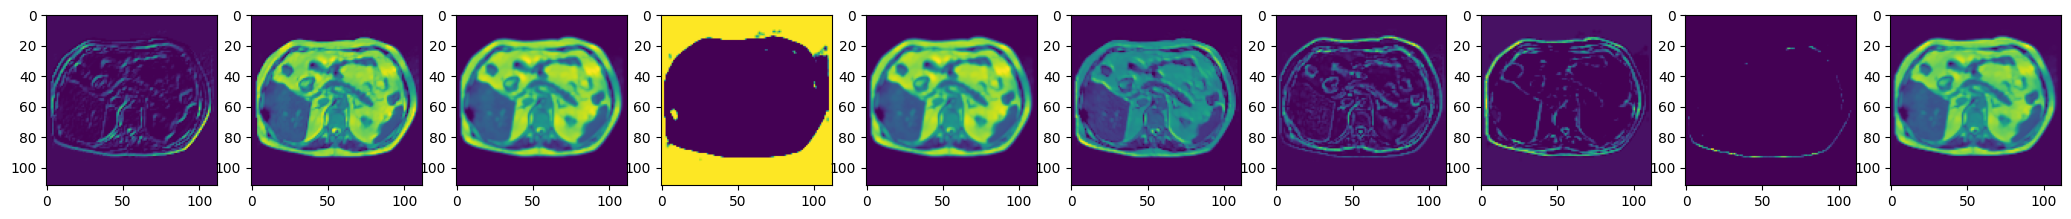

In [546]:
view_features(output_features[1][0][:,:,0:10])

10 valid images found: 1 rows and 10 columns


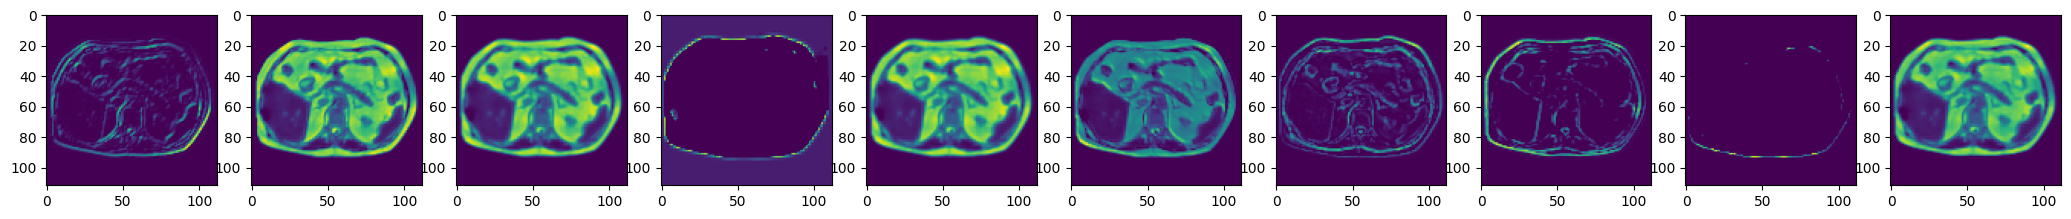

In [547]:
view_features(y[0][:,:,0:10])

In [508]:
y.shape

(1, 112, 112, 64)

## Start attention gate : Conv block 0 and 1x2x3x4x5

In [510]:
y, weights = attention_gate(model, output_features[0], y)

downscaled to:  (1, 112, 112, 64)
upscaled to:  (1, 224, 224, 1)


3 valid images found: 1 rows and 10 columns


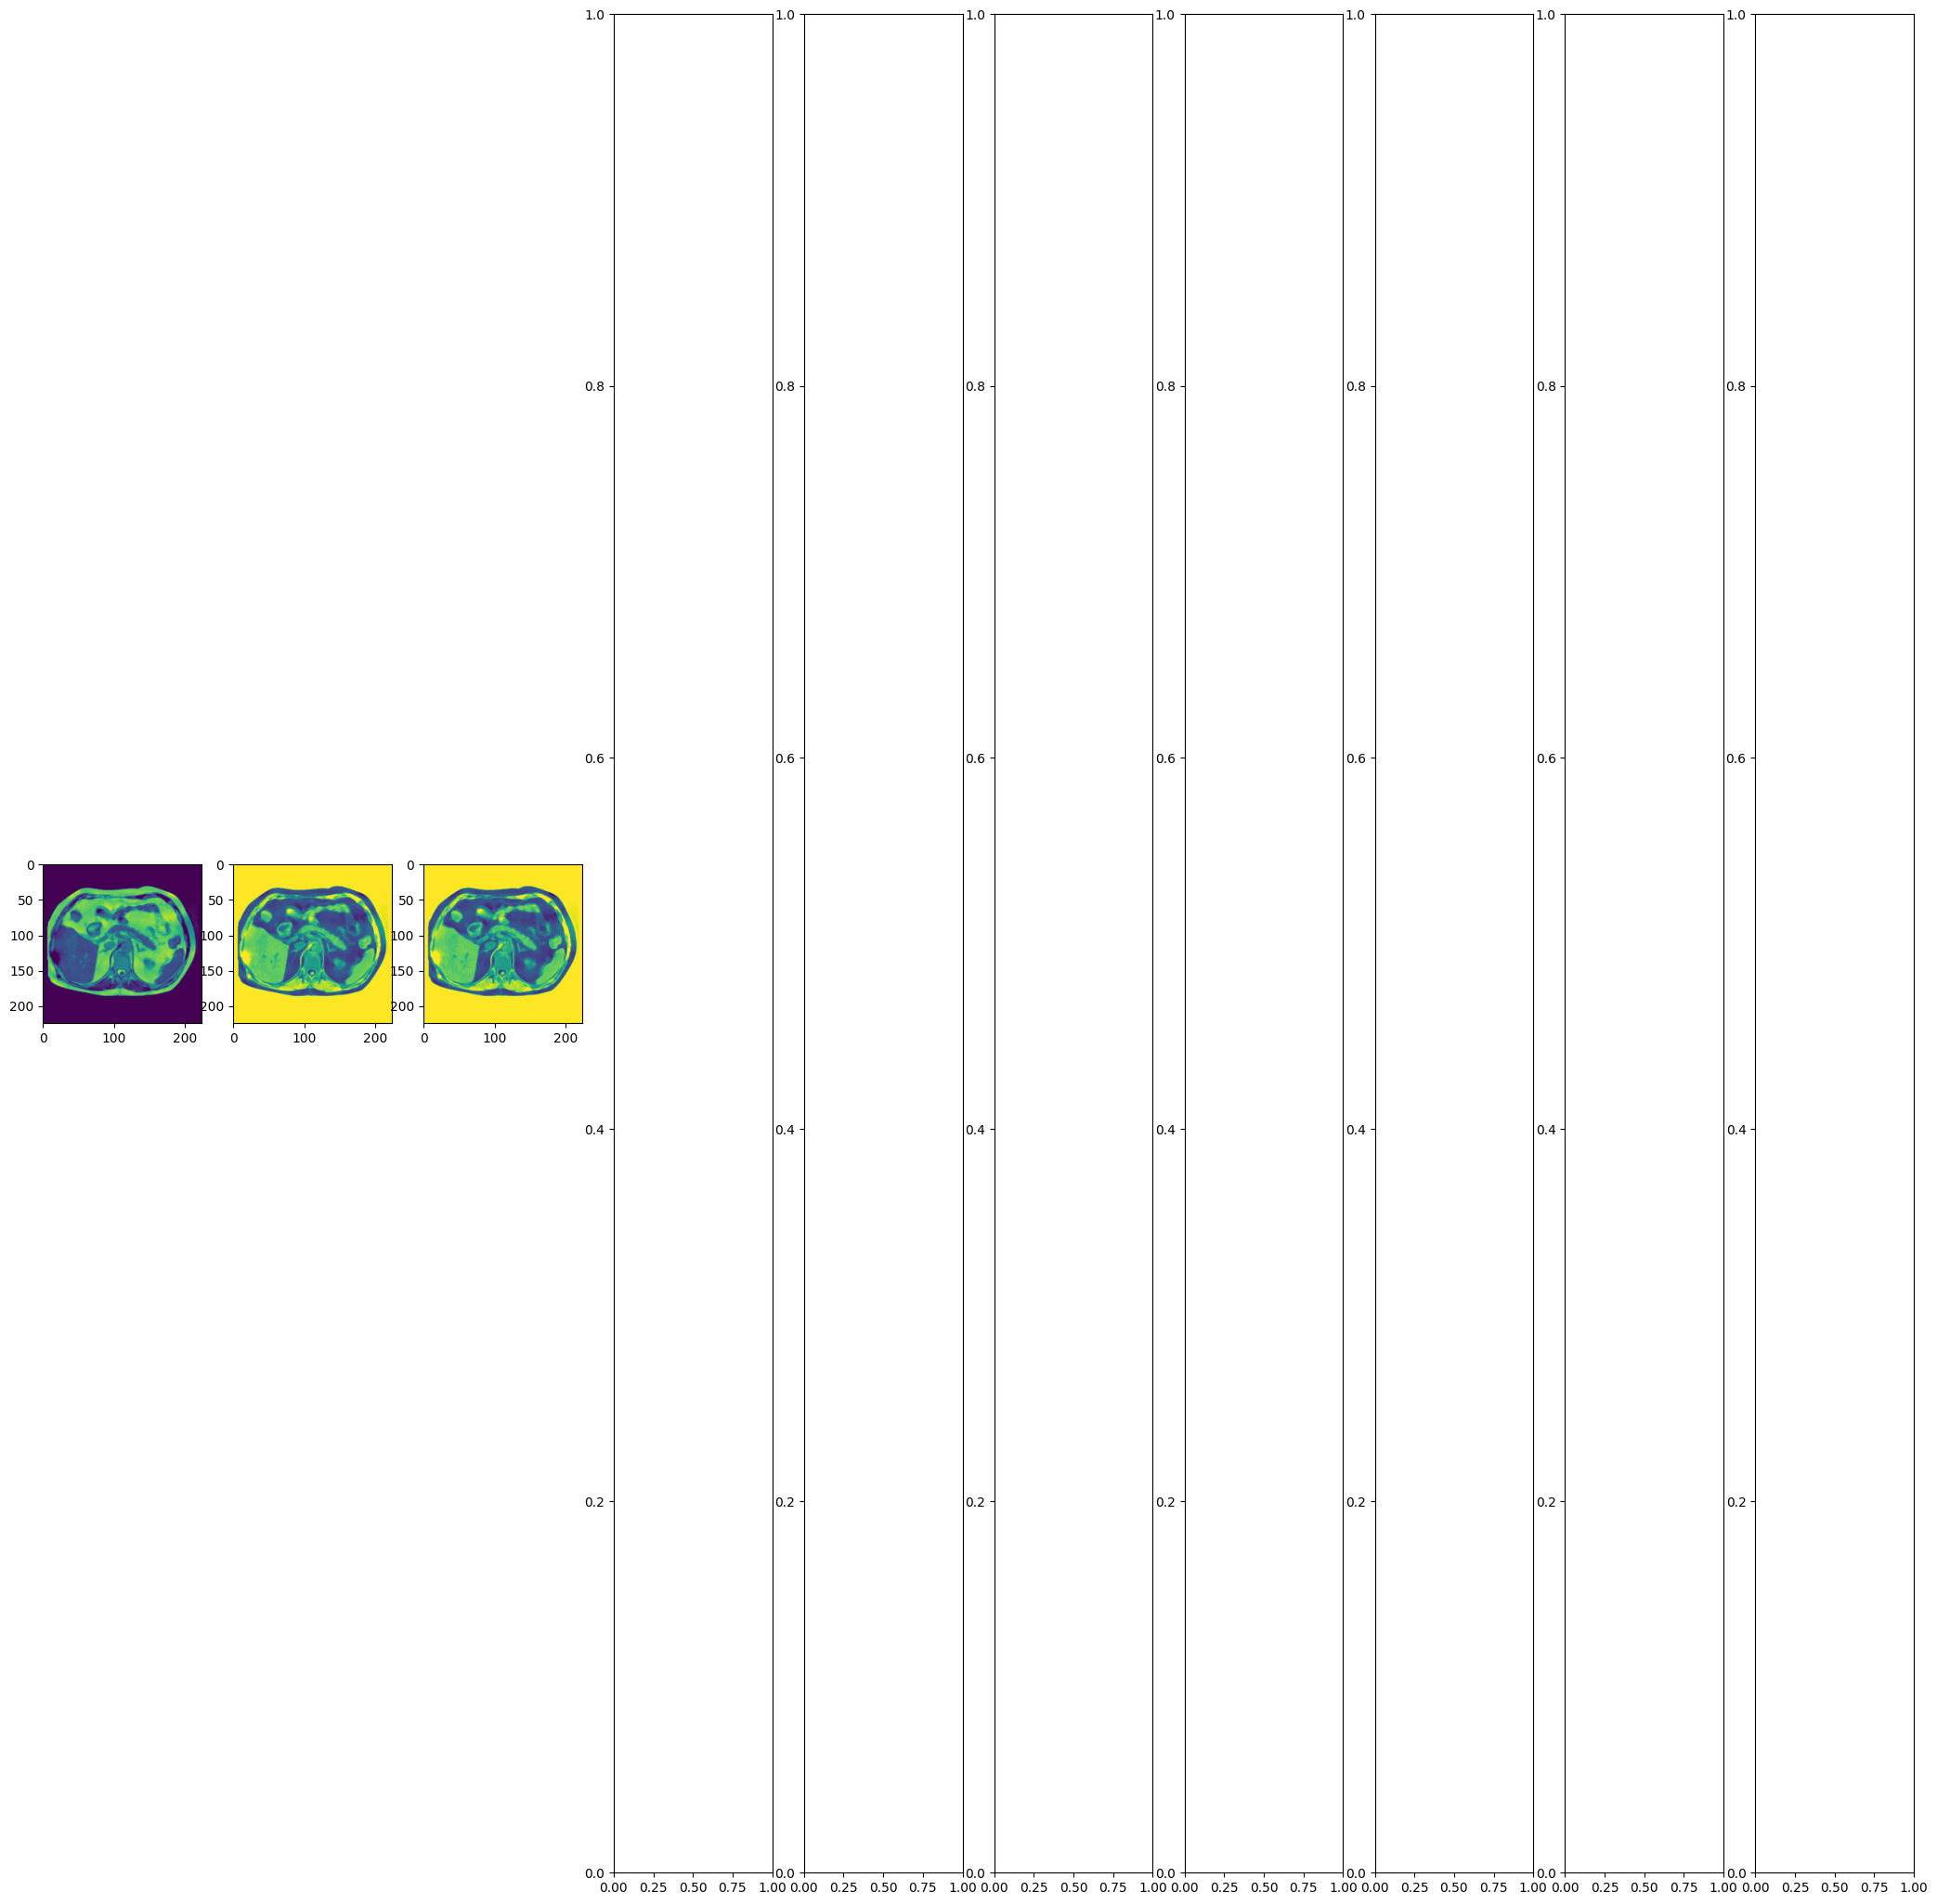

In [512]:
view_features(output_features[0][0][:,:,0:10])

3 valid images found: 1 rows and 10 columns


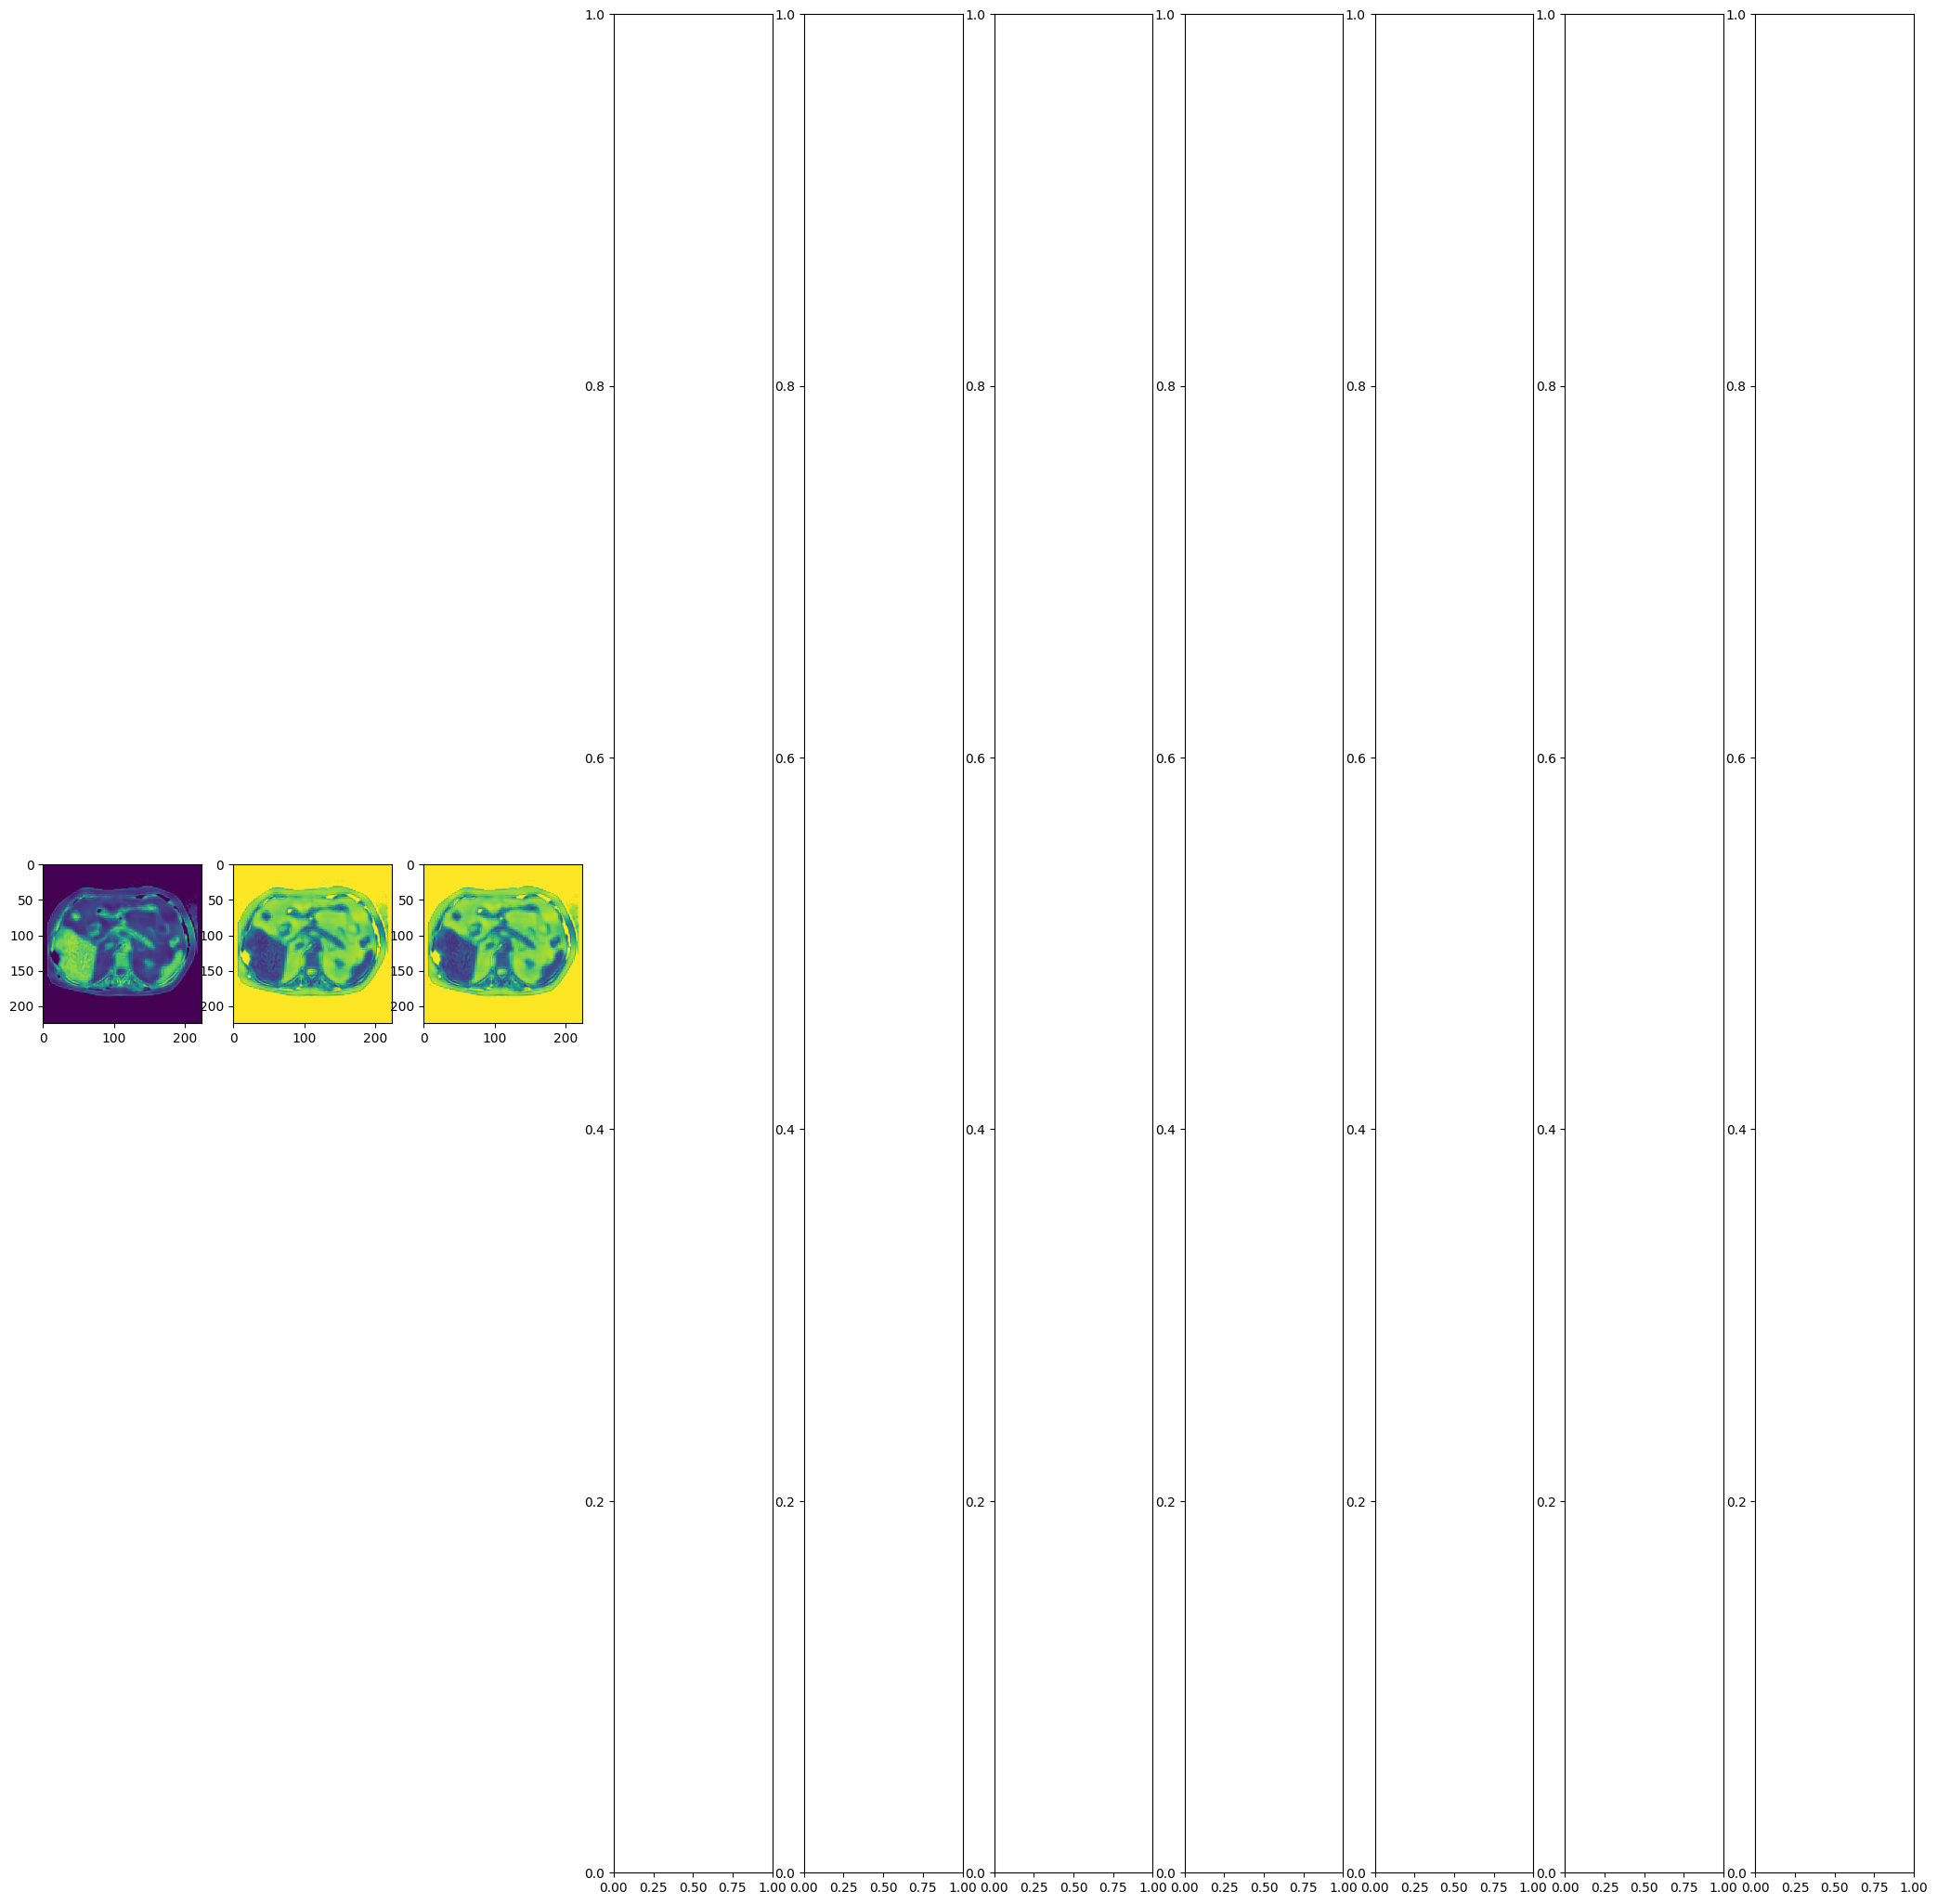

In [513]:
view_features(y[0][:,:,0:10])

In [ ]:
features = y[0]

flattened_features = features.reshape(-1, features.shape[2])

In [519]:
flattened_features.shape

(50176, 3)

In [529]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=101, n_init=30)
labels = kmeans.fit_predict(flattened_features)

In [530]:
labels_reshaped = labels.reshape(image_shape[0], image_shape[1])
labels_reshaped[labels_reshaped == 0] = 0
labels_reshaped[labels_reshaped == 1] = 51
labels_reshaped[labels_reshaped == 2] = 102
labels_reshaped[labels_reshaped == 3] = 151
labels_reshaped[labels_reshaped == 4] = 202
labels_reshaped[labels_reshaped == 5] = 255

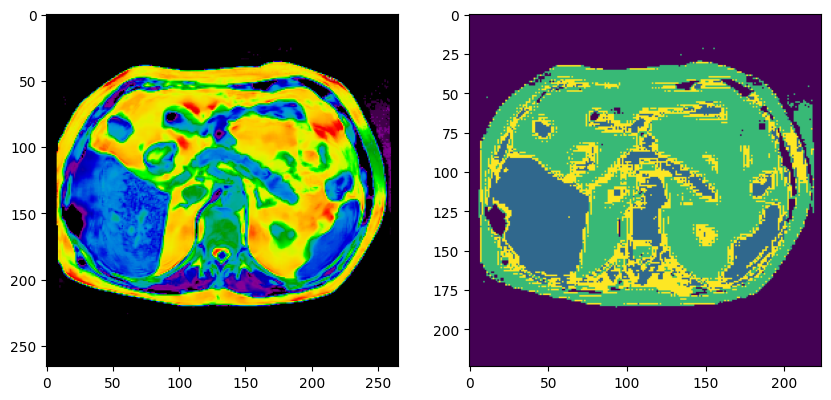

In [531]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(10,10))
axes[0].imshow(corrected_img, cmap='nipy_spectral')
axes[1].imshow(labels_reshaped)

# Applying pca after block 1

In [550]:
features = y[0]
features = upsample_features(features, (224,224))
flattened_features = features.reshape(-1, features.shape[2])

In [551]:
flattened_features.shape

(50176, 64)

In [581]:
pca = PCA(n_components=6)
pca_features = pca.fit_transform(flattened_features)

In [582]:
pca_features.shape

(50176, 6)

6 valid images found: 1 rows and 10 columns


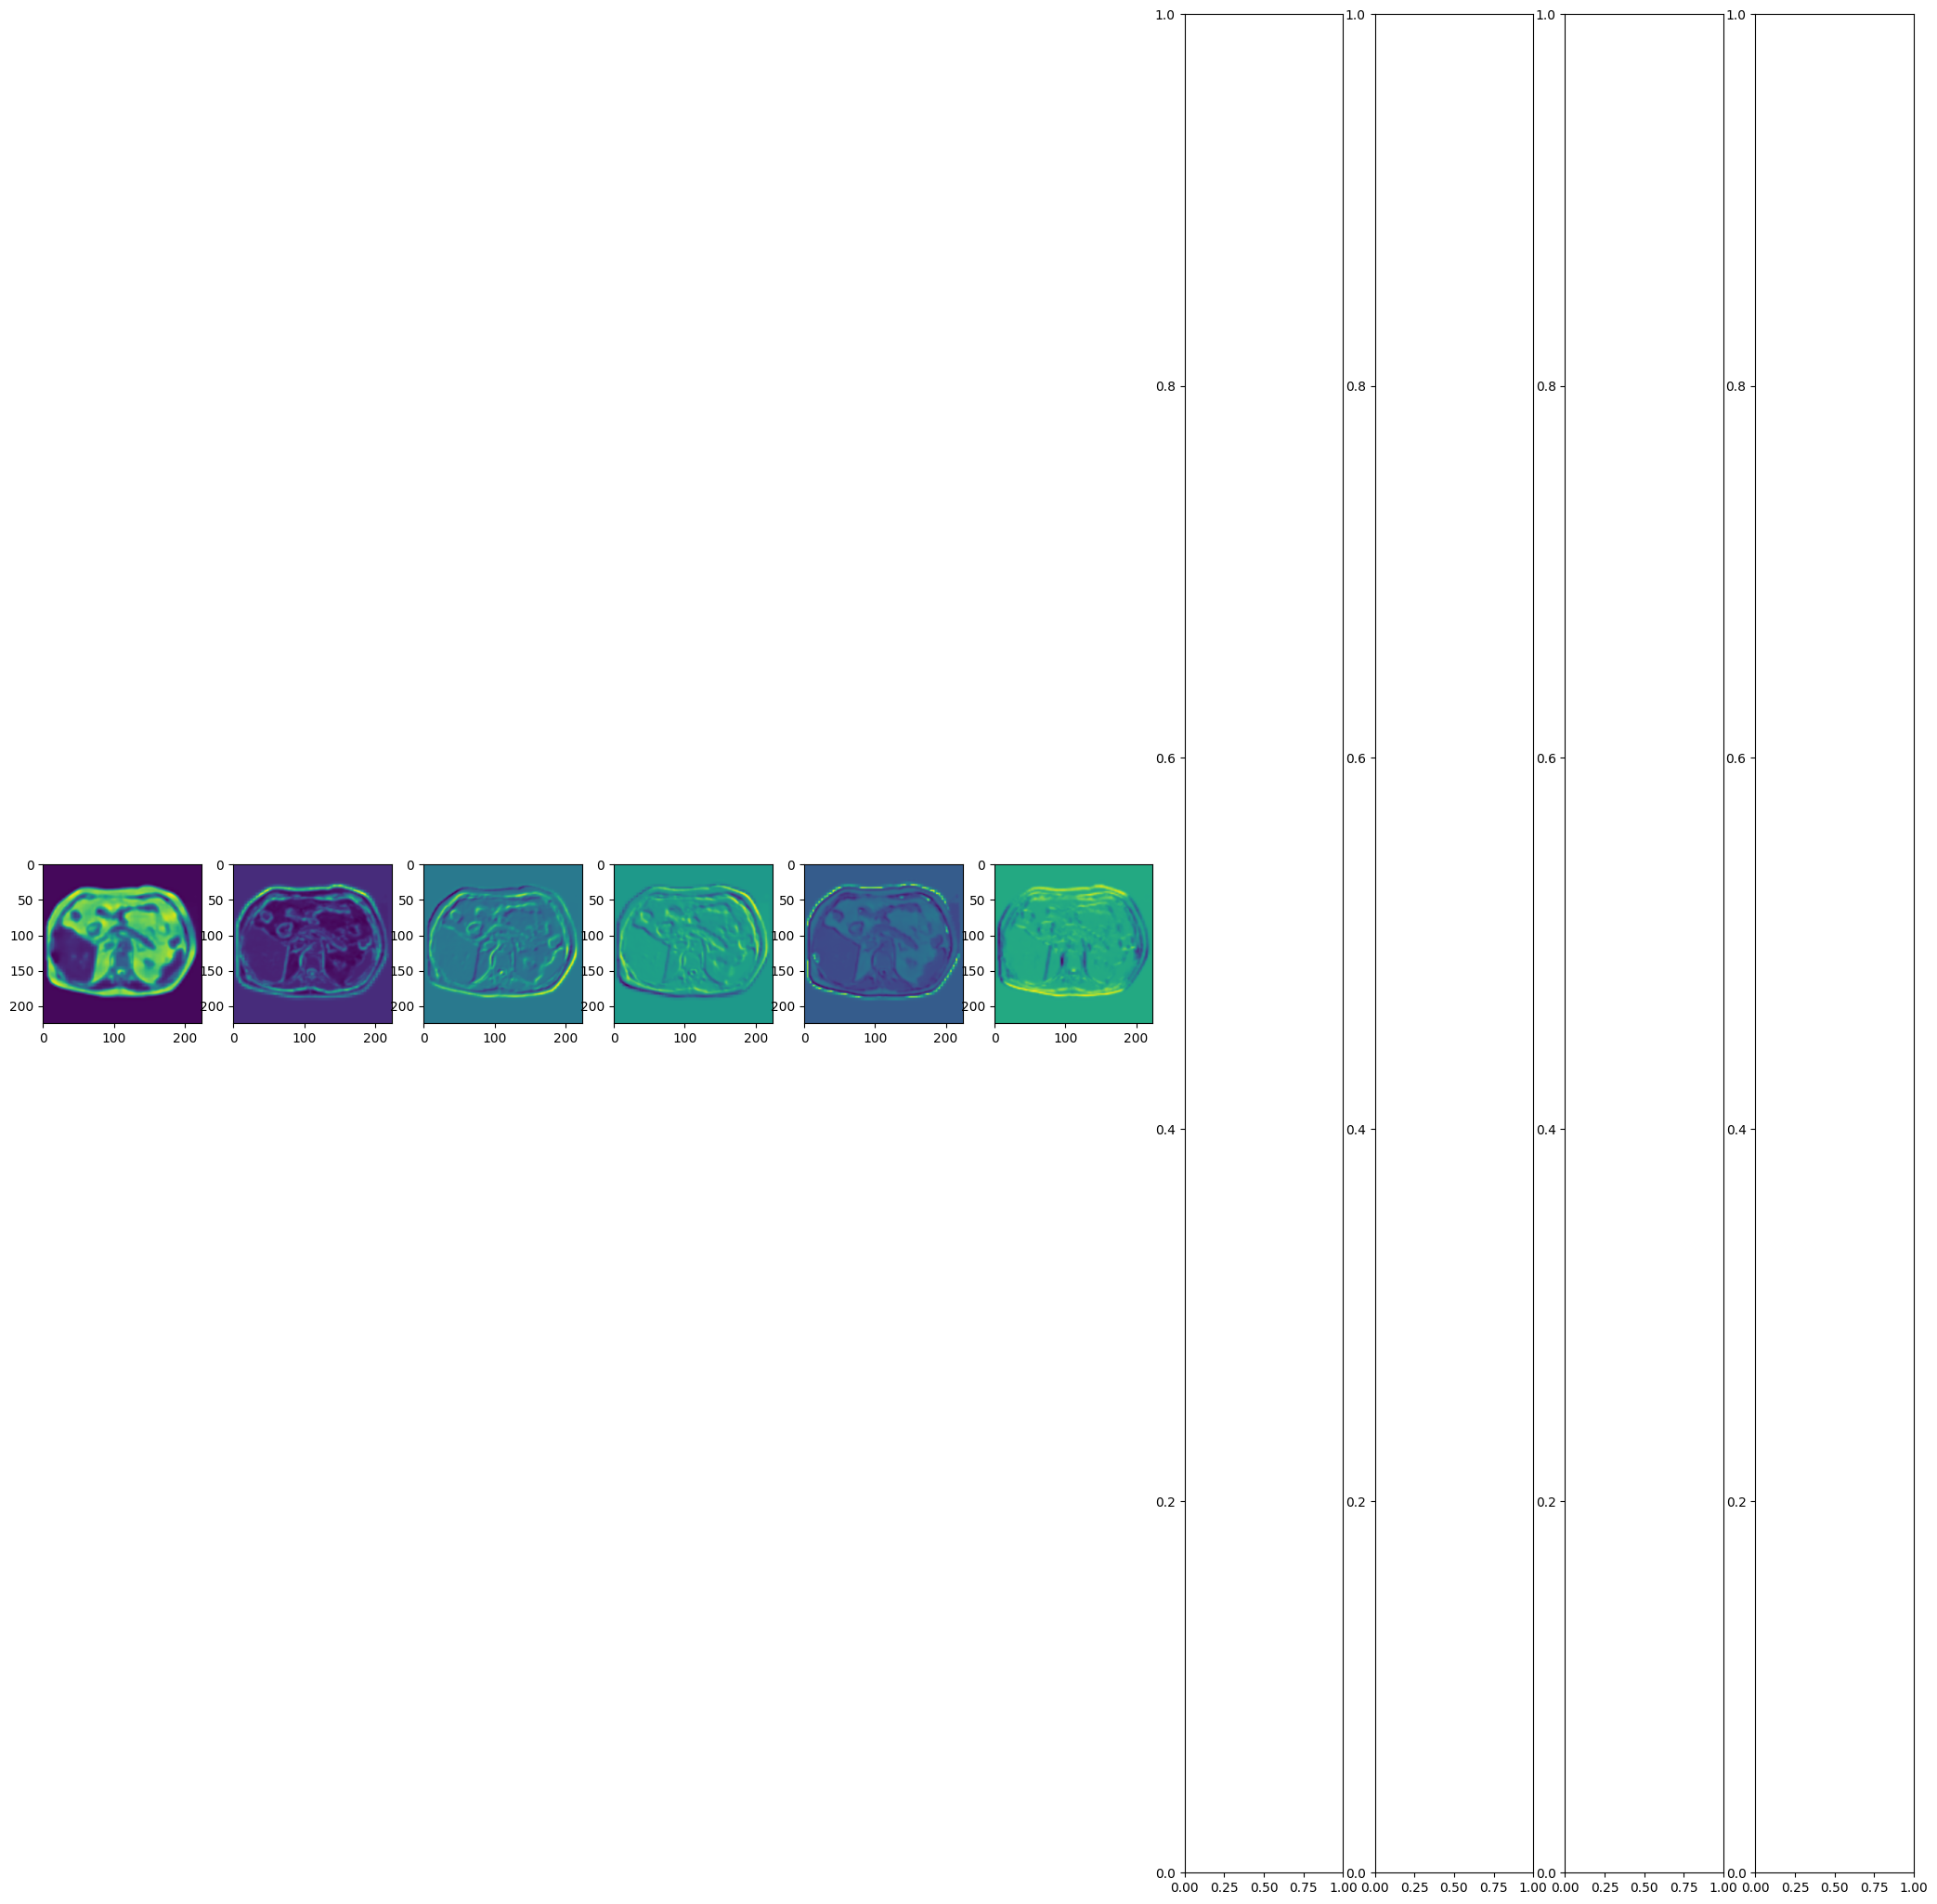

In [584]:
view_features(pca_features.reshape(224,224,6))

In [585]:
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=101, n_init=30)
labels = kmeans.fit_predict(pca_features[:,:3])

In [586]:
labels_reshaped = labels.reshape(image_shape[0], image_shape[1])
labels_reshaped[labels_reshaped == 0] = 0
labels_reshaped[labels_reshaped == 1] = 51
labels_reshaped[labels_reshaped == 2] = 102
labels_reshaped[labels_reshaped == 3] = 151
labels_reshaped[labels_reshaped == 4] = 202
labels_reshaped[labels_reshaped == 5] = 255

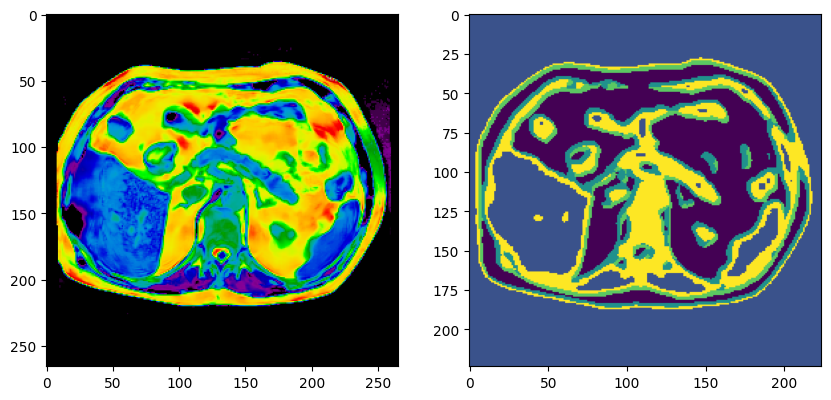

In [587]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(10,10))
axes[0].imshow(corrected_img, cmap='nipy_spectral')
axes[1].imshow(labels_reshaped)

# Restnet